### 本教程教你如何使用 SVM 分类 [Mnist 数据集](http://yann.lecun.com/exdb/mnist/)

MNIST 有一个 60，000 个示例的训练集和 10，000 个示例的测试集。这些数字已经尺寸归一化，并在固定大小(28*28)的图像中居中。

#### 1. 下载数据集

简单的话，可以通过 Scikit-Learn 获取 MNIST。

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784")

/home/h/miniconda3/lib/python3.8/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


#### 2. 分析数据集


In [2]:
print(mnist.keys())  # 看下数据集中有啥键，'data', 'target' 分别为 特征(就是每张图像)和标签
print(mnist['DESCR']) # 打印下说明

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])
**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a resul

查看下 数据维度和类型

In [3]:
mnist["data"].shape, mnist["target"].shape, type(mnist["target"])

((70000, 784), (70000,), pandas.core.series.Series)

为了方便，我们将 panda 对象转为 numpy

In [6]:
x = mnist["data"].to_numpy()
y = mnist["target"].to_numpy()
x.shape, y.shape

((70000, 784), (70000,))

画图显示下数据和对应的标签

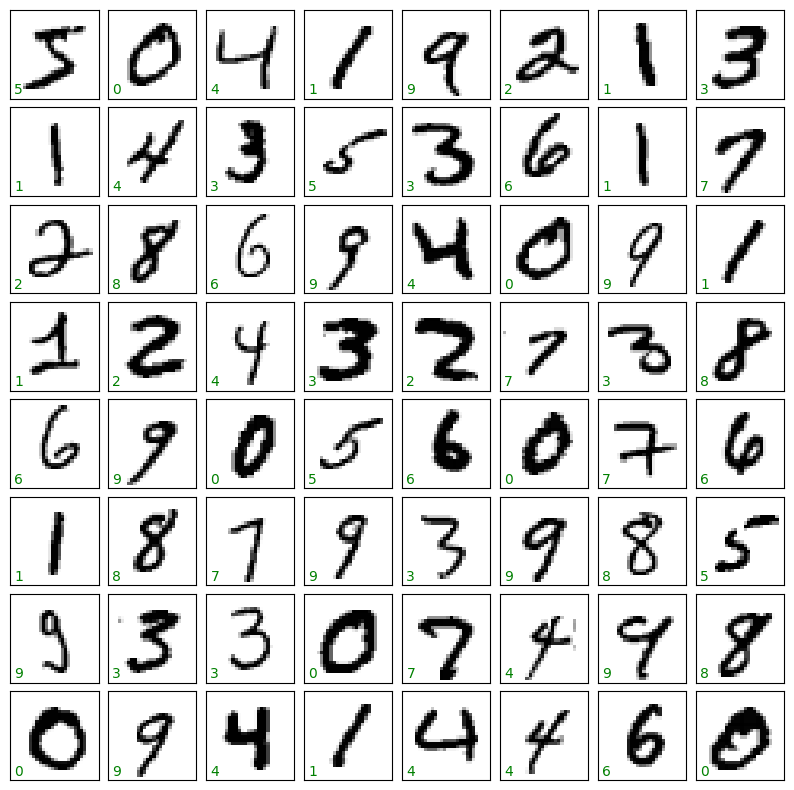

In [7]:
import matplotlib.pyplot as plt

# 8 行 8 列
fig, axes = plt.subplots(8, 8, figsize=(10, 10),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
# 绿的是 标签值
for i, ax in enumerate(axes.flat):
    ax.imshow(x[i].reshape(28, 28), cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(y[i]),
            transform=ax.transAxes, color='green')

#### 3. 数据划分

In [12]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, random_state=42)
Xtrain.shape, ytrain.shape

((52500, 784), (52500,))

#### 4. 定义模型对象

In [9]:
from sklearn.svm import SVC
model = SVC(kernel='rbf', class_weight='balanced')

#### 5. 训练模型

In [13]:
model.fit(Xtrain, ytrain) # 需要花一些时间

SVC(class_weight='balanced')

将训练好的模型来跑下测试集

In [15]:
ypred = model.predict(Xtest) # 需要花一些时间

统计下模型分类精度

In [16]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ypred)

0.9765142857142857

默认的参数看来模型不太行啊，没有达到 99%。下面画以下 混淆矩阵

Text(113.9222222222222, 0.5, 'true value')

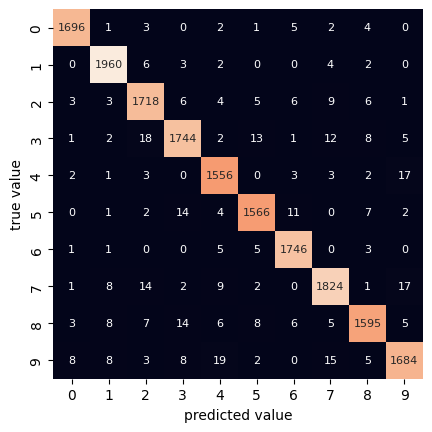

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(ytest, ypred)

sns.heatmap(mat, square=True, annot=True, cbar=False, fmt='.20g', annot_kws={"fontsize":8}) # fmt：不用科学计数法
plt.xlabel('predicted value')
plt.ylabel('true value')

预测错误的 标注为 红色，对的为 绿色

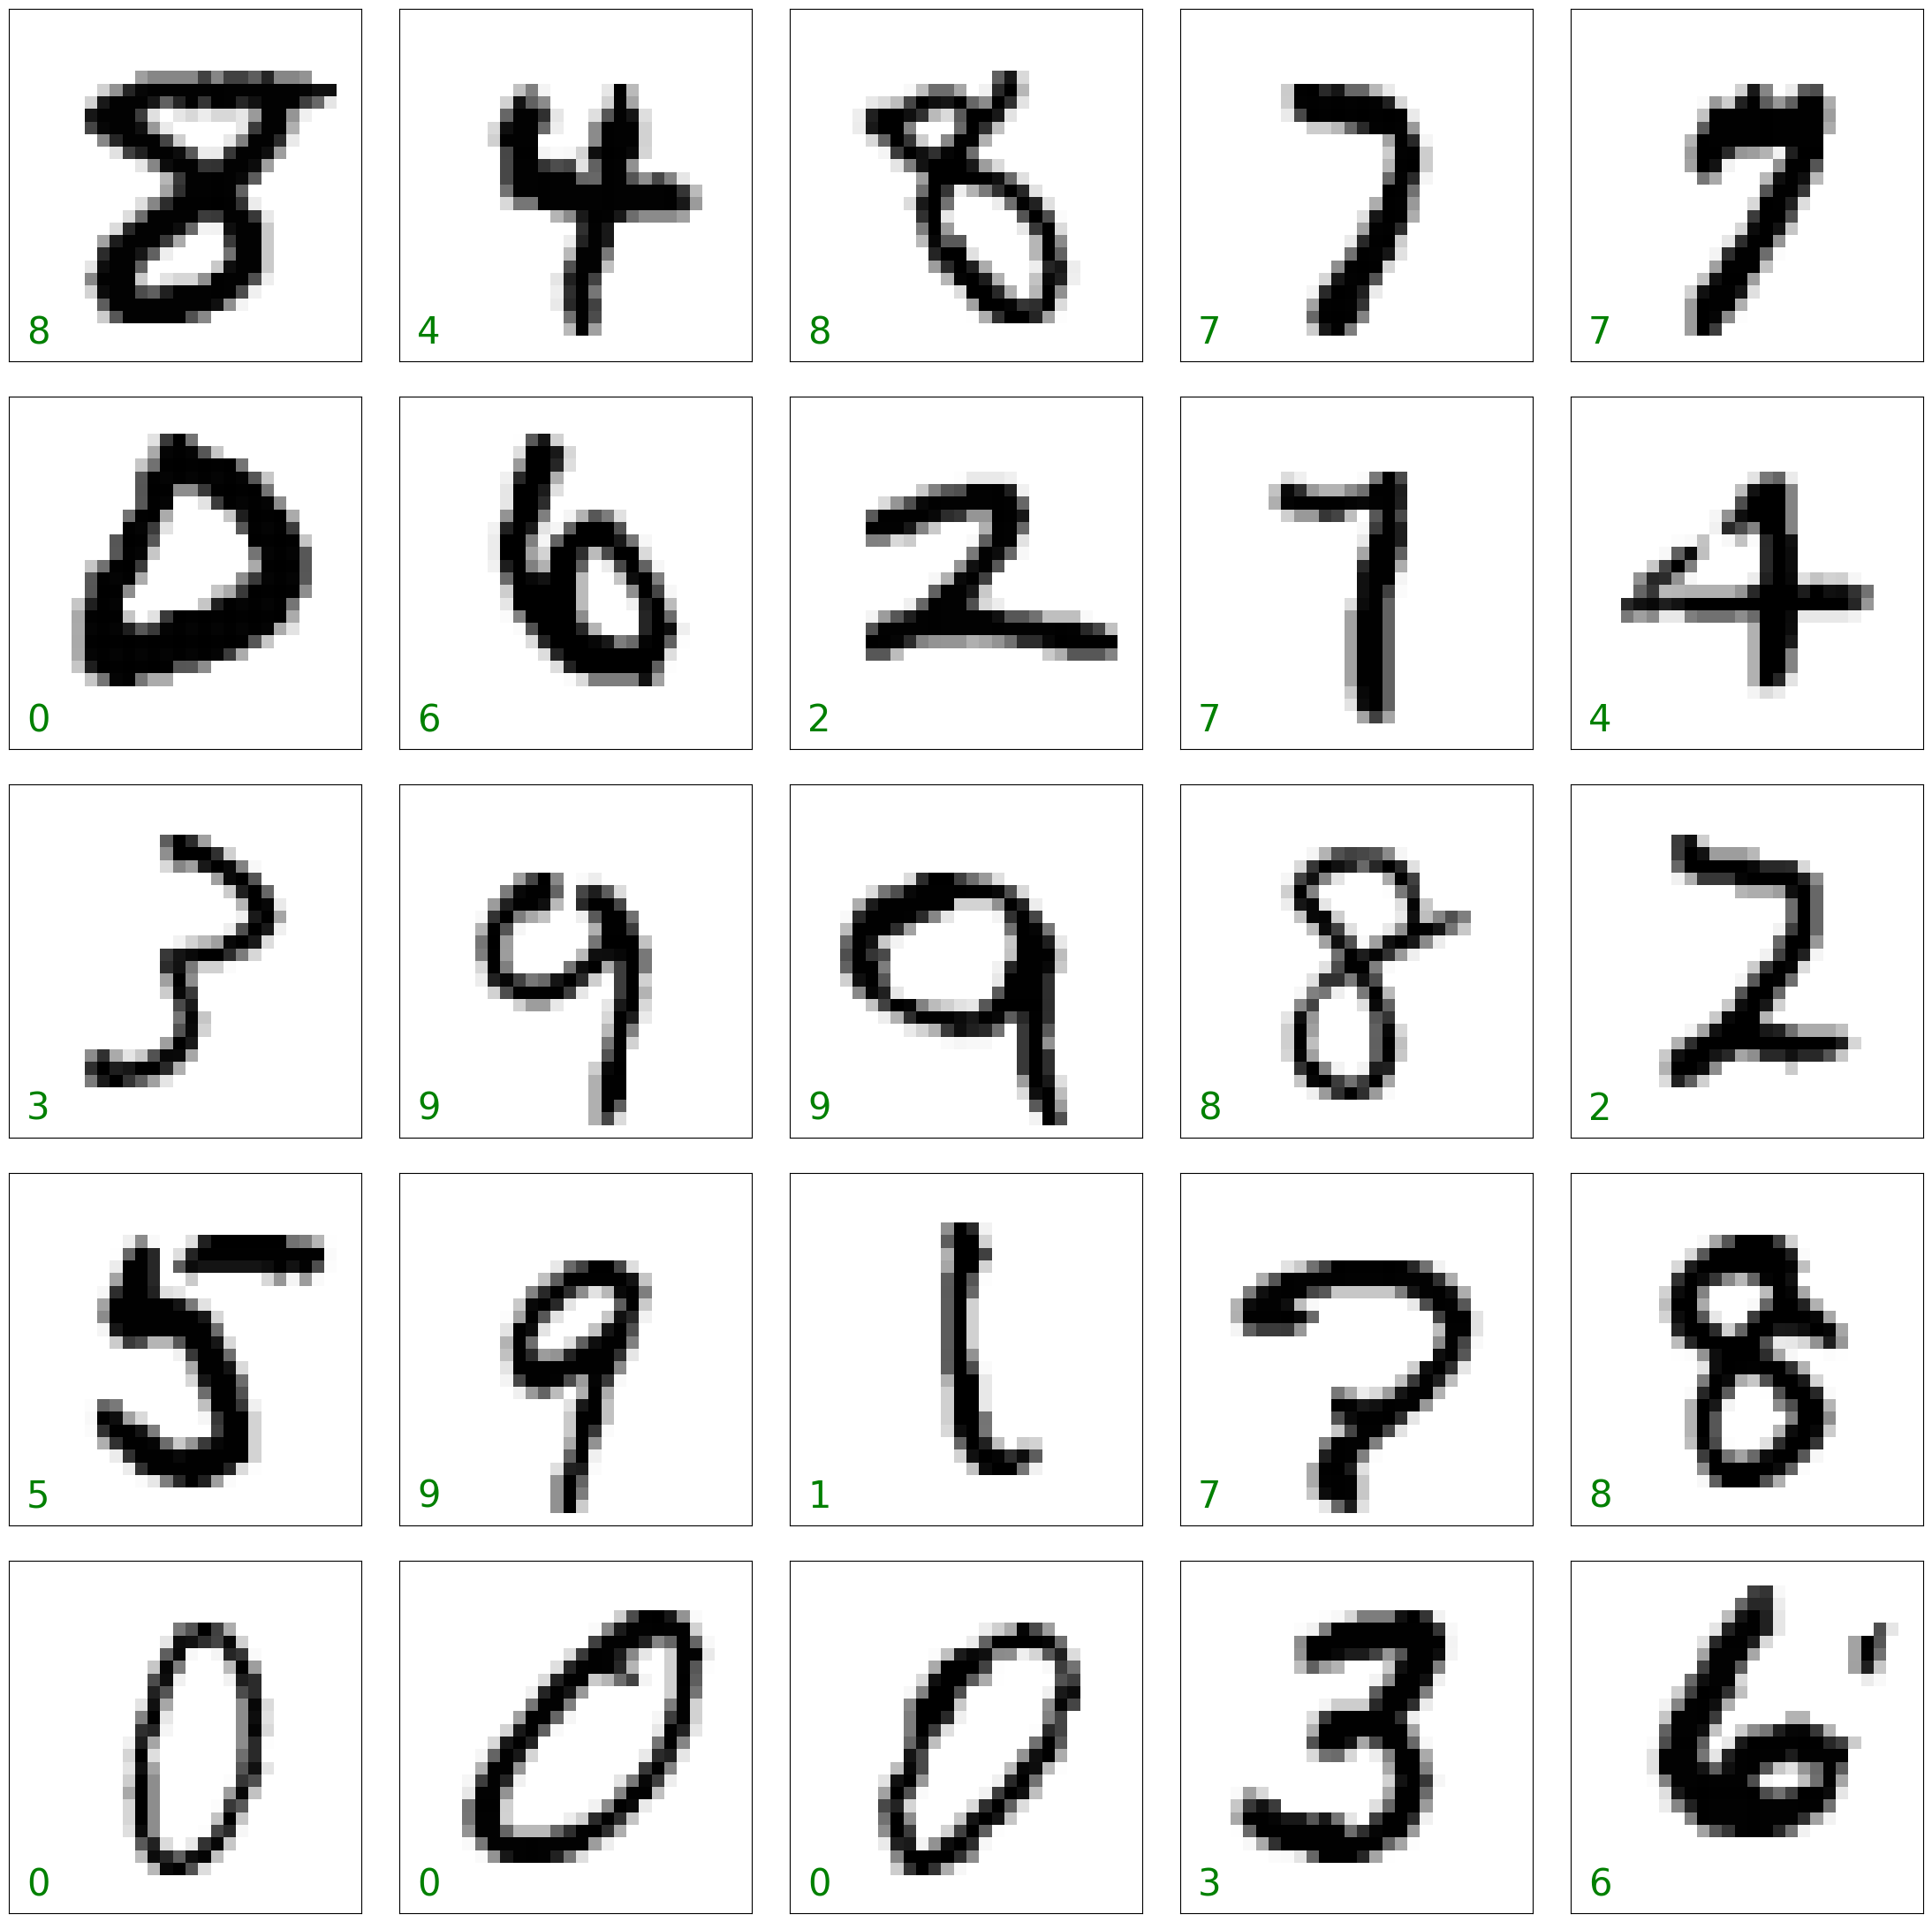

In [18]:
fig, axes = plt.subplots(5, 5, figsize=(28, 28),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

test_images = Xtest.reshape(-1, 28, 28)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(ypred[i]),
            transform=ax.transAxes,
            color='green' if (ytest[i] == ypred[i]) else 'red',
            fontsize=30)

统计结果

In [19]:
from sklearn.metrics import classification_report
target_names = list(mnist['target'].cat.categories)
print(classification_report(ytest, ypred,
                            target_names=target_names))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1714
           1       0.98      0.99      0.99      1977
           2       0.97      0.98      0.97      1761
           3       0.97      0.97      0.97      1806
           4       0.97      0.98      0.97      1587
           5       0.98      0.97      0.98      1607
           6       0.98      0.99      0.99      1761
           7       0.97      0.97      0.97      1878
           8       0.98      0.96      0.97      1657
           9       0.97      0.96      0.97      1752

    accuracy                           0.98     17500
   macro avg       0.98      0.98      0.98     17500
weighted avg       0.98      0.98      0.98     17500



## PCA 降维+SVM 加速训练

In [21]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

# 28*28 降维为 10
pca = RandomizedPCA(n_components=10, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [22]:
model.fit(Xtrain, ytrain) # 速度明显加快，可以统计下时间

Pipeline(steps=[('pca', PCA(n_components=10, random_state=42, whiten=True)),
                ('svc', SVC(class_weight='balanced'))])

In [23]:
ypred = model.predict(Xtest)

In [24]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ypred)  # 降低了，看来 svm 的默认参数确实效果一般

0.9339428571428572

其余步骤请参考上面内容...